# Combinación de modelos de regresión

En el segundo ejercicio aprenderemos dos cosas:

1. Cómo implementar un modelo de regresión compuesto de múltiples modelos más sencillos de manera que obtengamos mejores resultados con la combinación que con cada uno de los modelos por separado.
2. Cómo implementar un algoritmo de regresión similar a los que podemos encontrar en la librería *scikit-learn* extendiendo la clase *RegressorMixin*.

En primer lugar, prepararemos tres conjuntos de datos sintéticos donde podremos probar nuestra implementación.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn import datasets
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

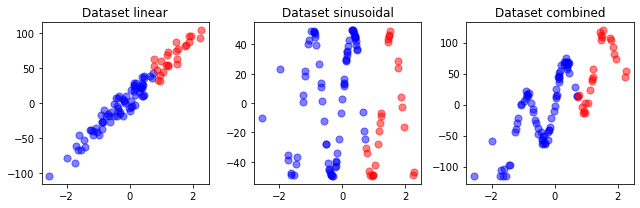

In [3]:
# Cada variable (data_linear, data_sinusoidal y data_combined) será una tupla con cinco posiciones:
# el nombre del dataset y los dos valores X e y tanto para casos de interpolación como de extrapolación.
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=9, noise=9, random_state=0)
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_linear = ('linear', X[:75], y[:75], X[-25:], y[-25:])
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=5, noise=5, random_state=0)
y = (50*np.sin(5*X)).ravel()
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_sinusoidal = ('sinusoidal', X[:75], y[:75], X[-25:], y[-25:])
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=5, noise=5, random_state=0)
y += (50*np.sin(5*X)).ravel()
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_combined = ('combined', X[:75], y[:75], X[-25:], y[-25:])

# Guardamos todos los datasets en una tupla.
datasets_tuple = (data_linear, data_sinusoidal, data_combined)

# Y mostramos su distribución bidimensional
fig, axis = plt.subplots(1, 3, figsize=(9,3))
for dataset, ax in zip(datasets_tuple, axis):
    ax.scatter(dataset[1], dataset[2], alpha=0.5, color='b', s=50, marker='o')
    ax.scatter(dataset[3], dataset[4], alpha=0.5, color='r', s=50, marker='o')
    ax.set_title('Dataset {}'.format(dataset[0]))

plt.tight_layout()

Los tres conjuntos de datos se dividen a su vez en dos subconjuntos: *train* (azul) y *test* (rojo). Los datos de *train* serán utilizados para entrenar el modelo, mientras que los de *test* jamás serán vistos por él.

La siguiente función nos ayudará a evaluar nuestra implementación del algoritmo de regresión mostrando cómo se comporta éste sobre cada uno de los tres conjuntos de datos propuestos.

In [4]:
def plot_regressor(reg):
    fig, axis = plt.subplots(1, 3, figsize=(9,3))
    for dataset, ax in zip(datasets_tuple, axis):
        reg.fit(dataset[1], dataset[2])
        print(f'Dataset {dataset[0]}, '
              f'score interpolation: {reg.score(dataset[1], dataset[2])}, '
              f'score extrapolation: {reg.score(dataset[3], dataset[4])}')

        X_interpolation = np.linspace(
            np.min(dataset[1]), np.mean(np.array([np.max(dataset[1]), np.min(dataset[3])])), 7500
        ).reshape(-1, 1)
        X_extrapolation = np.linspace(
            np.mean(np.array([np.max(dataset[1]), np.min(dataset[3])])), np.max(dataset[3]), 2500
        ).reshape(-1, 1)

        ax.plot(X_interpolation, reg.predict(X_interpolation), color='b', linewidth=3)
        ax.scatter(dataset[1], dataset[2], alpha=0.5, color='b', s=100, marker='o')
        ax.plot(X_extrapolation, reg.predict(X_extrapolation), color='r', linewidth=3)
        ax.scatter(dataset[3], dataset[4], alpha=0.5, s=100, color='r')
        ax.set_title(f'Dataset {dataset[0]}')

La siguiente celda muestra cómo podemos utilizar la función *plot_regressor* sobre un algoritmo de regersión que cumple con los estándares de *scikit-learn*.

Dataset linear, score interpolation: 1.0, score extrapolation: -1.3458417109611087
Dataset sinusoidal, score interpolation: 1.0, score extrapolation: -0.15418002495961636
Dataset combined, score interpolation: 1.0, score extrapolation: -0.7313473636504104


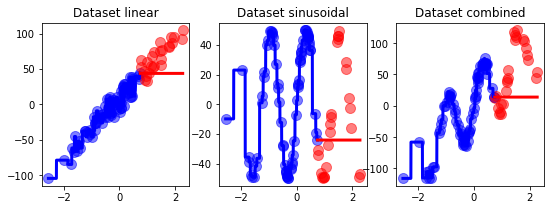

In [5]:
reg = DecisionTreeRegressor()
plot_regressor(reg)

La función implementada muestra, sobre las muestras de cada uno de los conjuntos de datos (representadas mediante círculos), las predicciones del modelo (representadas por la línea continua) para un intervalo de muestras conocido por el modelo (en azul) y para un intervalo de muestras que éste no ha visto (en rojo). El problema de predecir valores objetivo para muestras dentro del intervalo conocido se llama interpolación y es más sencillo que el problema de predecir valores para las muestras de fuera del intervalo conocido, llamado extrapolación.

## Implementación del modelo de regresión combinado

A continuación, construiremos un regresor siguiendo los estándares de *scikit-learn*, motivo por el que implementaremos nuestro algoritmo en una clase que heredará directamente de *RegressorMixin*, clase que, a su vez, nos aportará funcionalidad extra a través de los métodos `__init__`, `fit` y `predict` que ya habremos escrito nosotros. Dentro de dicha funcionalidad extra, se encuentra el método `score`, que calcula la precisión predictiva del modelo construido mediante nuestro algoritmo sobre un conjunto de atributos descriptivos de una serie de muestras y sus correspondientes valores objetivo. Cuanto más se acerque a 1.0 el valor de `score`, mejor será el modelo predictivo.

La siguiente clase, a modo ilustrativo, implementa un regresor muy sencillo que se limitará a asignar siempre, en sus predicciones, el valor objetivo medio visto en las muestras de aprendizaje.

En el método `__init__` guardamos todos los parámetros necesarios para el modelo (en este caso realmente no hace falta ninguno), en el método `fit` calculamos la media de los valores objetivo y en el método `predict` asignaremos a todas las muestras dicha media, que previamente habremos calculado y guardado en el modelo llamando a `fit`.

In [7]:
class MeanRegressor(RegressorMixin):
    
    def __init__(self, parameter):
        #################################
        # Inicialización de parámetros.
        self._parameter = parameter
        #################################
    
    def fit(self, X, y):
        #################################
        # Creación del modelo.
        self._model = np.mean(y)
        #################################
    
    def predict(self, X):
        predictions = np.empty(np.size(X, 0))
        #################################
        # Predicción de las clases de las muestras de X.
        predictions[:] = self._model
        #################################
        return predictions

Finalmente, mostraremos cómo se comporta este sencillo algoritmo.

Dataset linear, score interpolation: 0.0, score extrapolation: -13.940505850650647
Dataset sinusoidal, score interpolation: 0.0, score extrapolation: -0.19952338451193175
Dataset combined, score interpolation: 0.0, score extrapolation: -1.67158792302086


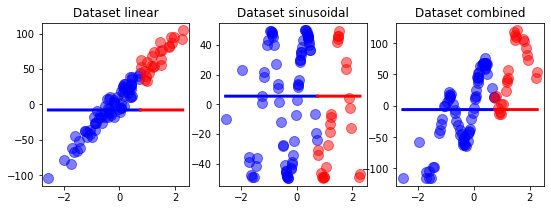

In [8]:
reg = MeanRegressor(parameter=None)
plot_regressor(reg)

En la teoría hemos visto el concepto de ensemble, mediante el cual podemos combinar distintos modelos predictivos en uno solo obteniendo un mejor resultado gracias a su unión. Uno de estos ensembles es el random forest, un bosque de árboles de decisión generados cada uno de ellos con un pequeño componente aleatorio. Dicho componente aleatorio se introduce de dos formas: generando un conjunto de muestras de forma aleatoria (bootstrapping) y seleccionando aleatoriamente un subconjunto de atributos descriptivos para cada árbol. De esta forma, cada árbol verá sólo una parte (diferente) del dato, horizontal y verticalmente.

El valor predicho por el random forest, en el caso de la regresión, será el valor promedio de todos los valores predichos por sus árboles de decisión.

In [9]:
class MyRandomForestRegressor(RegressorMixin):
    
    def __init__(self, n_estimators = 10, max_features = None, max_samples = 100, min_samples_split = 2, max_depth = None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_samples = max_samples
        self.min_samples_split =min_samples_split
        self.max_depth = max_depth
        self.trees = []
        self.create_trees()    
        
    def create_trees(self):
        for _ in range(self.n_estimators):
            model = DecisionTreeRegressor(
                max_features=self.max_features, 
                min_samples_split=self.min_samples_split, 
                max_depth = self.max_depth)
            # Se crean los árboles y se guardan en una lista
            self.trees.append(model)
    
    def fit(self, X, y):
        
        for model in self.trees:
            index = self.get_index(X)
            (X_temp, y_temp) = self.get_data(X, y, index)
            model.fit(X_temp, y_temp)
            
    def predict(self, X):
        # Se crea un acumulador de los datos predichos
        predictions = np.zeros(len(X))
        # Se guardan los datos predichos
        temp=[]
        
        # Con los datos de prueba se predicen los resultados a través de todos los áboles
        for model in self.trees:
            rs = model.predict(X)
            temp.append(rs)
        
        # Se obtiene el promedio de las predicciones
        for i in range(self.n_estimators):
            predictions += temp[i]/self.n_estimators
                    
        return predictions
    
    def get_data(self, X, y, index):
        if np.ndarray == type(X):
            return (X[index], y[index])
        elif pd.core.frame.DataFrame == type(X):
            return (X.loc[index], y[index])
    
    def get_index(self, X):
        if np.ndarray == type(X):
            return resample(range(0, len(X)), n_samples=self.max_samples)
        elif pd.core.frame.DataFrame == type(X):
            return resample(X_train.index, n_samples=self.max_samples)

Dataset linear, score interpolation: 0.924944196215117, score extrapolation: -1.9753048957199342
Dataset sinusoidal, score interpolation: 0.84218376547865, score extrapolation: -1.1461020478172834
Dataset combined, score interpolation: 0.9304798001147638, score extrapolation: -0.6142880302393816


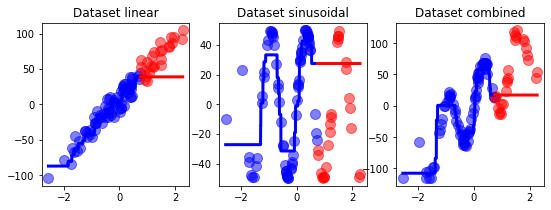

In [10]:
np.random.seed(42)
my_regressor = MyRandomForestRegressor(n_estimators=5, max_depth = 3, min_samples_split = 10, max_samples = 50)
plot_regressor(my_regressor)